In [ ]:
import numpy as np

import torch
from torch import nn
from torch.nn import functional as F
from tqdm.notebook import tqdm

import torchvision
from torchvision import datasets, transforms

from matplotlib import pyplot as plt
from IPython.display import clear_output

## In this notebook, I will solve the problem of classifying images of the CIFAR dataset into 10 classes

### Loading data

CIFAR10 — is a dataset of color images divided into 10 classes. Among the pictures are images of cars, airplanes, animals.

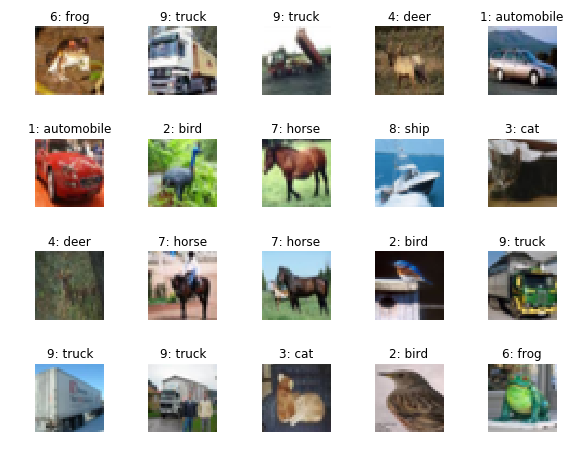

In [75]:
train_data = datasets.CIFAR10(root="./cifar10_data", train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.CIFAR10(root="./cifar10_data", train=False, download=True, transform=transforms.ToTensor())

# разделим тренировочную выборку на train и val
# в тренировочную выборку отнесем 80% всех картинок
train_size = int(len(train_data) * 0.8)
# в валидационную — остальные 20%
val_size = len(train_data) - train_size

train_data, val_data = torch.utils.data.random_split(train_data, [train_size, val_size])

# заведем даталоадеры
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


Let's look at a few pictures to understand what we are dealing with

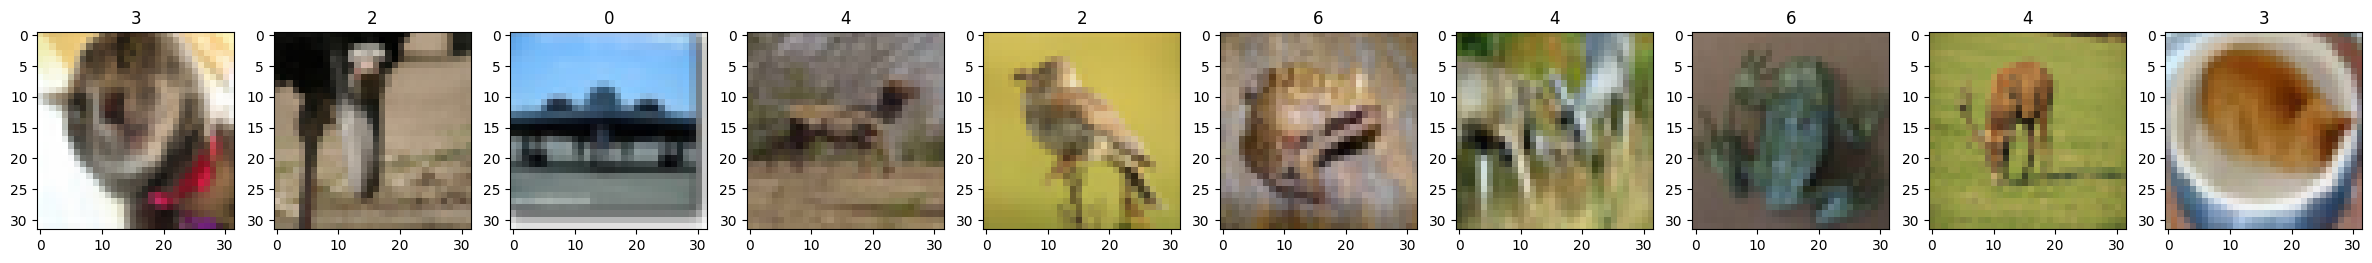

In [76]:
# this function renders multiple images
def show_images(images, labels):
    f, axes= plt.subplots(1, 10, figsize=(30,5))

    for i, axis in enumerate(axes):
        # translating the image from tensor to numpy
        img = images[i].numpy()
        # transfer the image in dimensions (length, width, color channels)
        img = np.transpose(img, (1, 2, 0))

        axes[i].imshow(img)
        axes[i].set_title(labels[i].numpy())

    plt.show()

# get a batch of images from the train dataloader
for batch in train_loader:
    # butch of pictures and butch of feedback to pictures
    images, labels = batch
    break

# calling the image rendering function
show_images(images, labels)

Let's see what size the pictures are:

In [77]:
images.shape

torch.Size([64, 3, 32, 32])

Here 64 is the size of the batch, 3 is the number of color channels (because the picture is colored, RGB) 32 and 32 are the width and height of the picture.

It turns out that each picture is represented by 32 * 32 * 3 = 3072 values. And there should be 3072 neurons in the first layer of the network.

### Building a model

In [79]:
from torch.nn.modules.batchnorm import BatchNorm1d


class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = torch.nn.Flatten()
        self.fc_in = nn.Linear(3072, 1024)
        self.bn_in = BatchNorm1d(1024)
        self.fc1 = nn.Linear(1024, 256)
        self.bn1 = BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 64)
        self.bn2 = BatchNorm1d(64)
        self.fc_out = nn.Linear(64, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc_in(x))
        x = self.bn_in(x)
        x = F.relu(self.fc1(x))
        x = self.bn1(x)
        x = F.relu(self.fc2(x))
        x = self.bn2(x)
        x = self.fc_out(x)
        return x

In [81]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [82]:
device

device(type='cuda')

In [83]:
model = Model().to(device)

## Checking the model

In [84]:
assert model is not None, 'Переменная model пустая. Где же тогда ваша модель?'

try:
    x = images.reshape(-1, 3072).to(device)
    y = labels

    # compute outputs given inputs, both are variables
    y_predicted = model(x)
except Exception as e:
    print('С моделью что-то не так')
    raise e


assert y_predicted.shape[-1] == 10, 'В последнем слое модели неверное количество нейронов'


### Model Training

In [85]:
from sklearn.metrics import accuracy_score

def evaluate(model, dataloader, loss_fn):

    y_pred_list = []
    y_true_list = []
    losses = []


    for i, batch in enumerate(tqdm(dataloader)):
        X_batch, y_batch = batch
        with torch.no_grad():

            logits = model(X_batch.to(device))

            loss = loss_fn(logits, y_batch.to(device))
            loss = loss.item()

            losses.append(loss)

            y_pred = torch.argmax(logits, dim=1)

        y_pred_list.extend(y_pred.cpu().numpy())
        y_true_list.extend(y_batch.numpy())

    accuracy = accuracy_score(y_pred_list, y_true_list)

    return accuracy, np.mean(losses)

In [86]:
def train(model, loss_fn, optimizer, n_epoch=6):

    model.train(True)

    data = {
        'acc_train': [],
        'loss_train': [],
        'acc_val': [],
        'loss_val': []
    }

    for epoch in tqdm(range(n_epoch)):

        for i, batch in enumerate(tqdm(train_loader)):

            X_batch, y_batch = batch

            logits = model(X_batch.to(device))

            loss = loss_fn(logits, y_batch.to(device))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print('On epoch end', epoch)

        acc_train_epoch, loss_train_epoch = evaluate(model, train_loader, loss_fn)
        print('Train acc:', acc_train_epoch, 'Train loss:', loss_train_epoch)

        acc_val_epoch, loss_val_epoch = evaluate(model, val_loader, loss_fn)
        print('Val acc:', acc_val_epoch, 'Val loss:', loss_val_epoch)


        data['acc_train'].append(acc_train_epoch)
        data['loss_train'].append(loss_train_epoch)
        data['acc_val'].append(acc_val_epoch)
        data['loss_val'].append(loss_val_epoch)

    return model, data

In [87]:
model = Model().to(device)

loss_fn = torch.nn.CrossEntropyLoss()

learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [88]:
model, data = train(model, loss_fn, optimizer, n_epoch=10)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

On epoch end 0


  0%|          | 0/625 [00:00<?, ?it/s]

Train acc: 0.42875 Train loss: 1.5944635728836059


  0%|          | 0/157 [00:00<?, ?it/s]

Val acc: 0.4191 Val loss: 1.6356819564369833


  0%|          | 0/625 [00:00<?, ?it/s]

On epoch end 1


  0%|          | 0/625 [00:00<?, ?it/s]

Train acc: 0.46585 Train loss: 1.4922647645950318


  0%|          | 0/157 [00:00<?, ?it/s]

Val acc: 0.4498 Val loss: 1.5465064496751044


  0%|          | 0/625 [00:00<?, ?it/s]

On epoch end 2


  0%|          | 0/625 [00:00<?, ?it/s]

Train acc: 0.487625 Train loss: 1.4258618638992309


  0%|          | 0/157 [00:00<?, ?it/s]

Val acc: 0.4591 Val loss: 1.5087715888478954


  0%|          | 0/625 [00:00<?, ?it/s]

On epoch end 3


  0%|          | 0/625 [00:00<?, ?it/s]

Train acc: 0.512025 Train loss: 1.3698750440597534


  0%|          | 0/157 [00:00<?, ?it/s]

Val acc: 0.4793 Val loss: 1.4689735515861755


  0%|          | 0/625 [00:00<?, ?it/s]

On epoch end 4


  0%|          | 0/625 [00:00<?, ?it/s]

Train acc: 0.52645 Train loss: 1.3272672749519348


  0%|          | 0/157 [00:00<?, ?it/s]

Val acc: 0.4838 Val loss: 1.4514314103278385


  0%|          | 0/625 [00:00<?, ?it/s]

On epoch end 5


  0%|          | 0/625 [00:00<?, ?it/s]

Train acc: 0.54035 Train loss: 1.2902562134742737


  0%|          | 0/157 [00:00<?, ?it/s]

Val acc: 0.4917 Val loss: 1.4287021144939835


  0%|          | 0/625 [00:00<?, ?it/s]

On epoch end 6


  0%|          | 0/625 [00:00<?, ?it/s]

Train acc: 0.557075 Train loss: 1.2468100470542909


  0%|          | 0/157 [00:00<?, ?it/s]

Val acc: 0.5038 Val loss: 1.412227913832209


  0%|          | 0/625 [00:00<?, ?it/s]

On epoch end 7


  0%|          | 0/625 [00:00<?, ?it/s]

Train acc: 0.5672 Train loss: 1.2164163899421692


  0%|          | 0/157 [00:00<?, ?it/s]

Val acc: 0.5056 Val loss: 1.410597673267316


  0%|          | 0/625 [00:00<?, ?it/s]

On epoch end 8


  0%|          | 0/625 [00:00<?, ?it/s]

Train acc: 0.578625 Train loss: 1.1830947053909302


  0%|          | 0/157 [00:00<?, ?it/s]

Val acc: 0.5095 Val loss: 1.4035044889541188


  0%|          | 0/625 [00:00<?, ?it/s]

On epoch end 9


  0%|          | 0/625 [00:00<?, ?it/s]

Train acc: 0.591875 Train loss: 1.1511247402191163


  0%|          | 0/157 [00:00<?, ?it/s]

Val acc: 0.5164 Val loss: 1.4001856047636385


### Quality assessment on a test sample

In [89]:
test_acc, test_loss = evaluate(model, test_loader, loss_fn)

  0%|          | 0/157 [00:00<?, ?it/s]

In [90]:
test_acc

0.5149

In [91]:
assert test_acc >= 0.5, 'Accuracy on the test >0.5! Not bad for a start'